# CoNLL Bias Analysis

In [70]:
import json
import math
import random
import spacy
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.util import minibatch, compounding
from tqdm.notebook import tqdm
from pathlib import Path

sns.set()
sns.set_style('white')

## Load Data

In [71]:
CONLL_ENRICHED_PATH = 'data/conll-enriched.json'
with open(CONLL_ENRICHED_PATH, 'r') as infile:
    conll_enriched_data = json.load(infile)
print(f'Loaded {len(conll_enriched_data)} entries from CoNLL-Enriched')

Loaded 20744 entries from CoNLL-Enriched


In [72]:
CONLL_BALANCED_PATH = 'data/conll-balanced.json'
with open(CONLL_BALANCED_PATH, 'r') as infile:
    conll_balanced_data = json.load(infile)
print(f'Loaded {len(conll_balanced_data)} entries from CoNLL-Balanced')

Loaded 21363 entries from CoNLL-Balanced


## Label Prevalence

In [73]:
def plot_label_prevalence(data_entries, title):
    labels = []
    for (_, annotations) in data_entries:
        labels += [annot['label'] for annot in annotations]
    sns.countplot(labels)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(title)

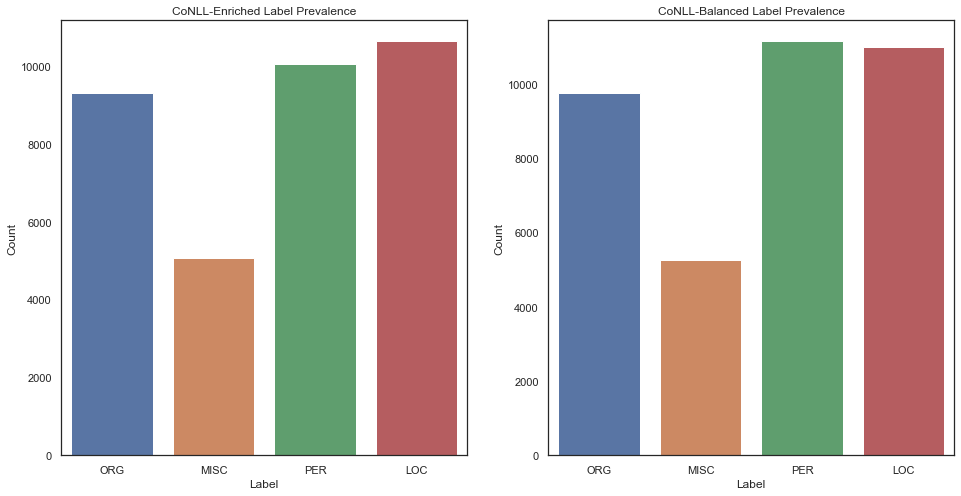

In [74]:
f = plt.gcf()
f.set_size_inches((16, 8))

plt.subplot(121)
plot_label_prevalence(conll_enriched_data, 'CoNLL-Enriched Label Prevalence')

plt.subplot(122)
plot_label_prevalence(conll_balanced_data, 'CoNLL-Balanced Label Prevalence')

plt.show()

In [76]:
# Build dict of name -> category
category_by_name = {}
for (_, annotations) in conll_balanced_data:
    for annot in annotations:
        if annot['label'] == 'PER':
            category_by_name[annot['text']] = annot['name_category']

## Investigate Name Distributions

In [77]:
# Extract all name categories
def get_name_categories(data_entries):
    name_categories = []
    for (_, annotations) in data_entries:
        for annot in annotations:
            if annot['label'] == 'PER':
                category = annot['name_category']
                name_categories.append(category)
    return name_categories
enriched_name_categories = get_name_categories(conll_enriched_data)
balanced_name_categories = get_name_categories(conll_balanced_data)

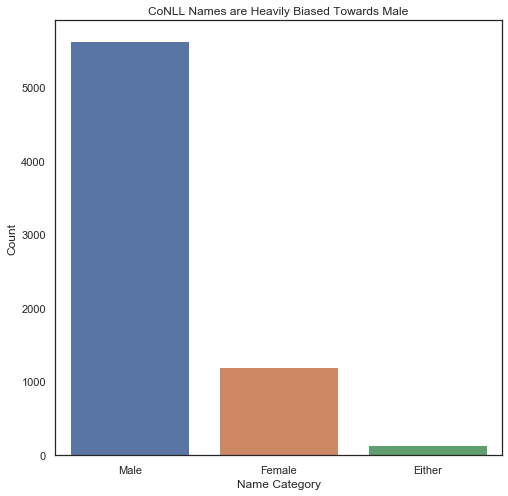

In [78]:
filtered_name_categories = [cat for cat in enriched_name_categories if cat != 'Unclear']

plt.gcf().set_size_inches((8, 8))
sns.countplot(filtered_name_categories)
plt.xlabel('Name Category')
plt.ylabel('Count')
plt.title('CoNLL Names are Heavily Biased Towards Male')
plt.show()

In [79]:
conll_female_count = sum(cat == 'Female' for cat in enriched_name_categories)
conll_balanced_female_count = sum(cat == 'Female' for cat in balanced_name_categories)

print(f'CoNLL,{conll_female_count}')
print(f'CoNLL-Balanced,{conll_balanced_female_count}')

CoNLL,1203
CoNLL-Balanced,1909


The results show a dramatic difference in representation among name categories. Male names are mentioned 5 times more than female names, and less than 2% of names were androgynous. This distribution of names is drastically different from the distribution of names among people in the world, which would be a major problem if a model were trained on this data and then used in a production system.

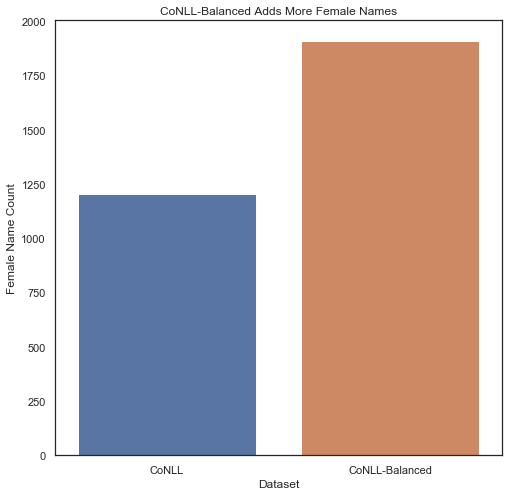

In [80]:
plt.gcf().set_size_inches((8, 8))
sns.barplot(x=['CoNLL', 'CoNLL-Balanced'], y=[conll_female_count, conll_balanced_female_count])
plt.xlabel('Dataset')
plt.ylabel('Female Name Count')
plt.title('CoNLL-Balanced Adds More Female Names')
plt.show()

We have augmented CoNLL 2003 with more data; specifically increasing the count of female names.

## Train a Model on Original CoNLL

### Load training and test data

In [81]:
filter_labels = ('PER',)
def convert_entry_to_spacy_format(entry, filter_labels):
    (text, annotations) = entry
    return (text,
            {
                'entities': [(annot['start'], annot['end'], annot['label'])
                             for annot in annotations if annot['label'] in filter_labels],
            })
def convert_data_to_spacy_format(data_entries, filter_labels):
    return [convert_entry_to_spacy_format(entry, filter_labels) for entry in data_entries]

In [82]:
count = len(conll_enriched_data)
random.seed(10)
random.shuffle(conll_enriched_data)
train_data = convert_data_to_spacy_format(conll_enriched_data[:int(count * 0.8)], ('PER',))
test_data = convert_data_to_spacy_format(conll_enriched_data[int(count * 0.8):], ('PER',))

### Training

In [83]:
def train_model(data, n_iter=40, existing_model=None):
    random.seed(0)
    if not existing_model:
        # Create blank spaCy English model
        nlp = spacy.blank('en')
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
        # Add PER label to our model
        ner.add_label('PER')

        optimizer = nlp.begin_training()
    else:
        nlp = existing_model
        optimizer = nlp.entity.create_optimizer()
    
    # Freeze all pipelines except for these exceptions to train NER on our data
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes):
        for itn in tqdm(range(n_iter)):
            random.shuffle(data)
            losses = {}
            batches = minibatch(data, 
                                size=compounding(4., 32., 1.001))
            for batch in batches:
                (texts, annotations) = zip(*batch) 
                # Update the weights
                nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
            print('Losses', losses)
    return nlp

In [102]:
# Load or train biased model
LOAD_BIASED_MODEL = True
if LOAD_BIASED_MODEL:
    biased_model = spacy.load('saved_models/biased_model')
else:
    biased_model = train_model(train_data)

## Train Model on CoNLL-Balanced

In [85]:
# Add augmented data
with open('data/conll-augment.json', 'r') as infile:
    augment_data = json.load(infile)
# Save first 50 for testing
balanced_train_data = train_data + convert_data_to_spacy_format(augment_data, filter_labels)[50:]

In [103]:
# Load or train balanced model
LOAD_BALANCED_MODEL = True
if LOAD_BALANCED_MODEL:
    balanced_model = spacy.load('saved_models/balanced_model')
else:
    balanced_model = train_model(balanced_train_data)

## Evaluate Model on Census Names

We evaluate the performance of the model on the template sentence “NAME is a person”, substituting the 100 most popular male and female names (since these are the only categories available) for each year of the US Census.

This method is inspired by Mehrabi et al. (https://arxiv.org/pdf/1910.10872.pdf), using the data from their experiment (https://github.com/Ninarehm/NERGenderBias).

In [87]:
years = list(range(1880, 2019))
limit = 100
def run_for_template_file(template_file, model):
    out_lines = []
    matches = 0
    with open(template_file, 'r') as infile:
        for line in infile.readlines():
            if len(out_lines) >= limit:
                break
            sentence = line.split(',')[0].strip()
            ents = model(sentence).ents
            if len(ents) > 0:
                out_lines.append(f'{ents[0].label_} {ents[0].text}')
                matches += int(ents[0].label_ in ('PER', 'PERSON'))
            else:
                out_lines.append('')
    return matches / limit
def run_for_template_dir(model, template_dir=Path('./templates')):
    recalls = []
    for year in tqdm(years):
        m_template_path = template_dir / f'male{year}.txt_withsent_isaperson'
        f_template_path = template_dir / f'female{year}.txt_withsent_isaperson'
        m_recall = run_for_template_file(m_template_path, model)
        f_recall = run_for_template_file(f_template_path, model)
        recalls.append({
            'category': 'Male',
            'recall': m_recall,
            'fnr': 1 - m_recall,
            'year': year,
        })
        recalls.append({
            'category': 'Female',
            'recall': f_recall,
            'fnr': 1 - f_recall,
            'year': year,
        })
    return pd.DataFrame(recalls)

In [89]:
census_recalls_biased = run_for_template_dir(biased_model)

In [90]:
census_recalls_balanced = run_for_template_dir(balanced_model)

In [91]:
def plot_census_analysis(false_neg_entries, model_type):
    f = plt.gcf()
    f.set_size_inches((16, 8))

    plt.subplot(121)
    sns.lineplot(data=false_neg_entries, x='year', y='fnr', hue='category')
    plt.xlabel('Census Year')
    plt.ylabel('False Negative Rate')
    plt.title(f'{model_type} False Negative Rates on Most Popular Names by Census Year')

    plt.subplot(122)
    sns.barplot(data=false_neg_entries, x='category', y='fnr')
    plt.xlabel('Name Category')
    plt.ylabel('Mean False Negative Rate')
    plt.title(f'{model_type} Mean False Negative Rates')

    plt.show()

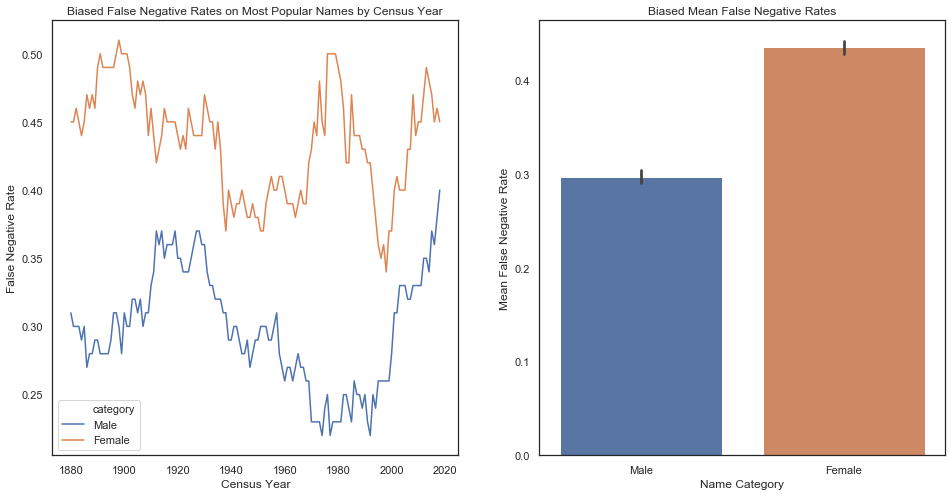

In [92]:
plot_census_analysis(census_recalls_biased, 'Biased')

We see that the model trained on original CoNLL 2003 performs significantly worse for female names across years of the census. Moreover, we see an interesting effect where the performance of the model steadily degrades in years after 1997. This makes sense because CoNLL consists of news articles published between 1996 and 1997.

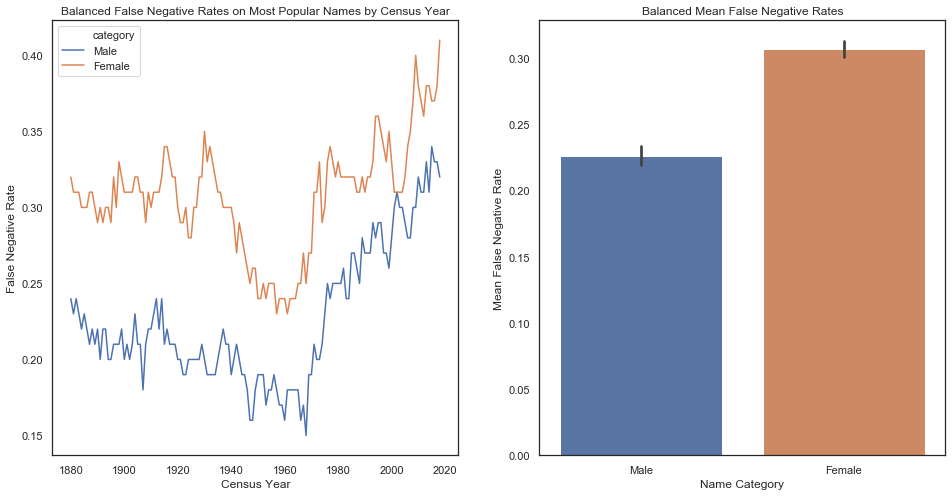

In [93]:
plot_census_analysis(census_recalls_balanced, 'Balanced')

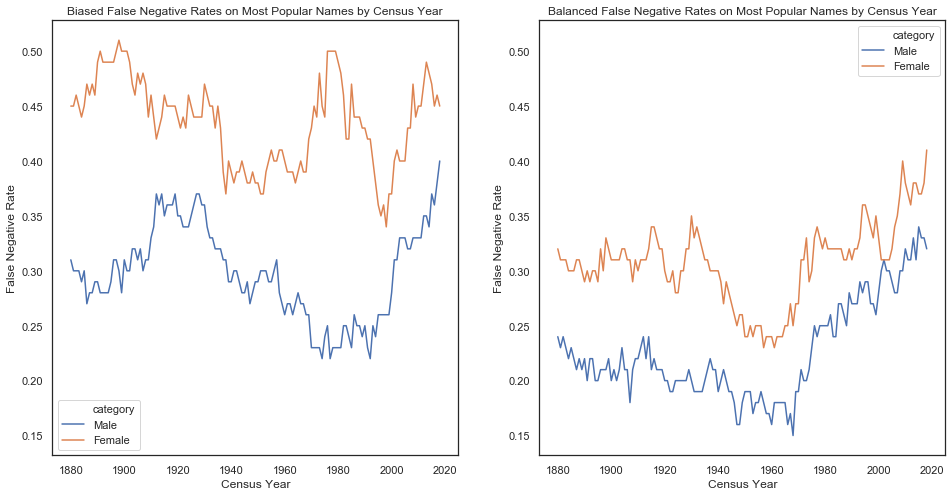

In [94]:
plt.gcf().set_size_inches((16, 8))

ax = plt.subplot(121)
sns.lineplot(data=census_recalls_biased, x='year', y='fnr', hue='category')
plt.xlabel('Census Year')
plt.ylabel('False Negative Rate')
plt.title(f'Biased False Negative Rates on Most Popular Names by Census Year')

plt.subplot(122, sharey=ax)
sns.lineplot(data=census_recalls_balanced, x='year', y='fnr', hue='category')
plt.xlabel('Census Year')
plt.ylabel('False Negative Rate')
plt.title(f'Balanced False Negative Rates on Most Popular Names by Census Year')
plt.show()

The model trained on CoNLL-balanced is much less biased and has equal performance on male and female names for all years until 1970. This shows that our augmented data has allowed the model to perform better on female names. 

Interestingly, the model performs worse on female names after 1970, which suggests that names from this period were not common in our augmented data source. To fix this, future work can find new training data that contains names from this period.

## Evaluate Models on Test Data

In [95]:
TEST_NAME_CATEGORIES = ('Male', 'Female', 'Either')

In [96]:
def extract_names(spacy_data):
    names = []
    for (text, data) in spacy_data:
        for (start, end, _) in data['entities']:
            names.append(text[start:end])
    return names

In [97]:
# Find all names that are present in test data but not in train data
test_data = test_data + convert_data_to_spacy_format(augment_data, filter_labels)[:50]
train_names = extract_names(train_data)
test_names = extract_names(test_data)

train_names_by_category = {}
test_names_by_category = {}
for category in TEST_NAME_CATEGORIES:
    train_names_by_category[category] = set(name for name in train_names if category_by_name[name] == category)
    test_names_by_category[category] = set(name for name in test_names if category_by_name[name] == category)

new_names_by_category = {}
for category in TEST_NAME_CATEGORIES:
    new_names_by_category[category] = test_names_by_category[category] - train_names_by_category[category]

In [104]:
def get_false_neg_entries(failed, total, name_type):
    false_neg_rates = []
    for key in TEST_NAME_CATEGORIES:
        false_neg_rates.append({
            'category': key,
            'fnr': failed[key] / total[key],
            'name_type': name_type,
        })
    return false_neg_rates

def get_false_negative_rate_by_category(model):
    failed = Counter()
    total = Counter()
    new_failed = Counter()
    new_total = Counter()
    for (text, data) in test_data:
        entries = model(text).ents
        for (start, end, _) in data['entities']:
            name = text[start:end]
            success = False
            for e in entries:
                if e.text == name:
                    success = True
                    break
            category = category_by_name[name]
            if category in TEST_NAME_CATEGORIES and name in new_names_by_category[category]:
                new_failed[category] += int(not success)
                new_total[category] += 1
            failed[category] += int(not success)
            total[category] += 1
    false_neg_rates = get_false_neg_entries(failed, total, 'seen') + get_false_neg_entries(new_failed, new_total, 'new')
    return pd.DataFrame(false_neg_rates)

In [105]:
biased_fnr_data = get_false_negative_rate_by_category(biased_model)
balanced_fnr_data = get_false_negative_rate_by_category(balanced_model)

In [106]:
def plot_fnr(data, title=''):
    sns.barplot(
        data=data.loc[np.logical_and(data['name_type'] == 'new', data['category'] != 'Either')],
        x='category',
        y='fnr')
    plt.title(title)
    plt.xlabel('Name Category')
    plt.ylabel('False Negative Rate')

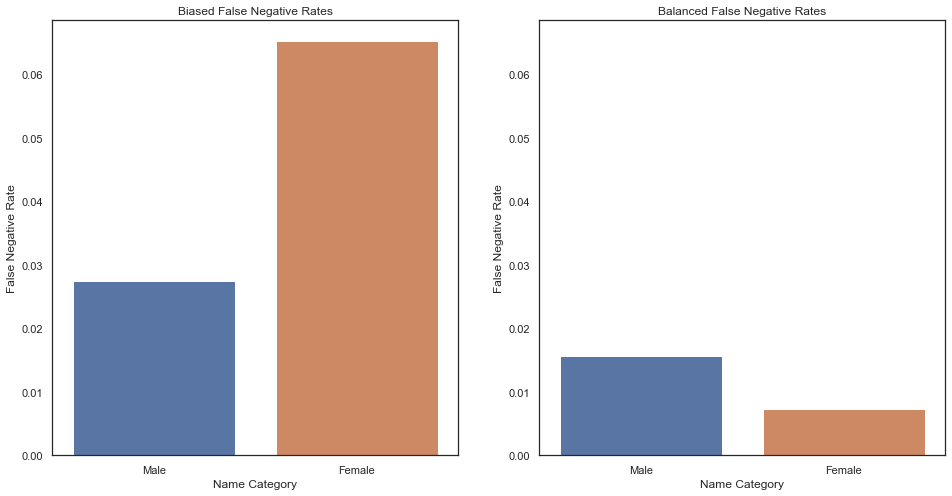

In [107]:
plt.gcf().set_size_inches((16, 8))

ax = plt.subplot(121)
plot_fnr(biased_fnr_data, 'Biased False Negative Rates')

plt.subplot(122, sharey=ax)
plot_fnr(balanced_fnr_data, 'Balanced False Negative Rates')

plt.show()